In [1]:
import gseapy as gp
import pandas as pd
import numpy as np
import scipy.stats as stats
import glob
from biomart import BiomartServer
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import gseapy as gp

from sklearn import decomposition
from sklearn import preprocessing

from scripts import aesthetics

aesthetics.activate_paper_rcParams()

pd.set_option("display.max_columns", 1000)

# Analyze SV impact on RNA

In `pgsvs-sv-impact-on-rna-generate.ipynb`, we have generate a huge dataset that fully details the impact of somatic SVs on tumor RNA expression. 

Here, we explore that dataset in further detail. It was getting cumbersome needing to work around generating the data.

# Import our data

We have a ton of data to import (the drawback of having multiple notebooks). I've short-cutted what data needs to be imported by exporting already formatted in data in `sv-impact-on-rna-generate`

In [2]:
analysis_tpms = pd.read_csv('data/tpms-for-sv-rna-analysis.csv')
analysis_tpms = analysis_tpms.iloc[:, 2:].set_index('gene_symbol')

analysis_dosages = pd.read_csv('data/dosages-for-sv-rna-analysis.csv')
analysis_dosages = analysis_dosages.iloc[:, 3:].set_index('ID')

analysis_svs = pd.read_csv('data/svs-for-sv-rna-analysis.csv')

# and our actual results
sv_rna_results = pd.read_csv('data/sv-expression-results/sv-gene-rna-results.csv')

/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (34,35,37,39,41,45,46,47) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
analysis_tpms.head(2)

,PT_02SNWVRF,PT_11XN6CG5,PT_1396H6SD,PT_1EQHANKW,PT_1RH3DTPB,PT_1X6CJ589,PT_1X9YQF9W,PT_21PJ8R0Z,PT_26E4RFYV,PT_2JZNQGTR,PT_2QB9MP9J,PT_2RZN4HR2,PT_2Y7Q85BM,PT_3VNMNFT6,PT_4Y3P2N1P,PT_56ZM694R,PT_5E269C8Z,PT_5FCYBT0S,PT_69AGBVQ5,PT_6DHGCDRP,PT_6WE8JADD,PT_70BK6DFW,PT_7APMD0HG,PT_7BAFX5PZ,PT_7E6A5N3P,PT_81RSHW1D,PT_82D2FJV2,PT_8DFBAQVQ,PT_9A9Q2YB3,PT_9QQ37AWW,PT_9X3MV3GW,PT_A77B7F2F,PT_AGYJR7PZ,PT_AQS8CCAB,PT_ASJZTDRF,PT_ATQMV6B3,PT_B39849MF,PT_C3YC0C9Q,PT_D5BYDHZ9,PT_DCBZYQAX,PT_E3R0MRXN,PT_E6CZS2KF,PT_EXZSSRGH,PT_F0QD1YWQ,PT_F2AFSP66,PT_FZ3XEWEK,PT_GGJ9E0VV,PT_GSWXPFPQ,PT_HA7TBZ1V,PT_HB9JT4G5,PT_HYJB8Y4N,PT_HZ4VWQP5,PT_JBQT2QPG,PT_JD8FVX6G,PT_JYRSHSWJ,PT_K0BJPWY9,PT_K3QMVST1,PT_K579G3KQ,PT_KBVX8B37,PT_M4ETZ912,PT_M8RHAK5K,PT_MK375DCF,PT_NK39AFPG,PT_P111JVHP,PT_PDYCQB6P,PT_PFRE83H3,PT_PV869ZYE,PT_Q50YZ2T5,PT_QF2A2F08,PT_QH23VVKW,PT_R94DDN50,PT_RVTVP55V,PT_SBS3N6ZT,PT_SDPQ63J1,PT_SV8ETF29,PT_TTHE7B08,PT_V3BXBVVV,PT_V65ESGCE,PT_VVVS471N,PT_W6AVZF18,PT_WWRAC6EH,PT_X8N7GE8X,PT_XPTE7785,PT_YGW6KQHQ,PT_YMDFCE4V,PT_YS31MFW0,PT_Z4S0193A,PT_ZK8Z4WAK,PT_ZT2NW6WA
gene_symbol,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TSPAN6,3.61,2.15,5.05,9.24,1.38,4.27,2.02,3.17,5.85,6.36,3.48,3.11,2.27,5.13,4.91,5.14,9.19,4.50,2.19,5.56,2.22,3.48,12.82,3.93,5.42,15.09,6.02,7.13,5.19,3.77,15.50,2.43,2.27,2.85,3.30,11.01,3.75,4.35,6.82,8.82,5.47,6.03,13.90,4.05,3.34,10.79,4.17,4.58,5.50,3.37,5.51,9.22,5.25,6.79,9.47,3.72,7.45,2.37,7.13,7.82,4.77,5.72,6.19,1.63,6.56,3.98,4.65,3.64,2.78,3.71,16.48,19.99,4.63,4.94,4.78,2.71,7.36,2.39,2.21,3.59,5.76,4.59,13.63,5.41,2.71,5.58,4.73,13.37,10.42
DPM1,6.62,7.87,9.53,6.47,8.50,8.60,4.42,14.89,6.82,8.34,11.18,6.19,14.00,9.55,10.03,10.89,7.57,10.69,16.08,9.30,8.82,6.57,8.18,8.04,6.04,10.48,10.56,6.59,9.23,9.81,7.94,6.79,13.07,11.07,15.11,8.91,16.16,7.94,6.96,8.88,7.65,8.60,12.84,7.12,4.40,5.96,6.23,9.24,8.51,4.64,9.08,7.29,9.21,12.98,8.29,6.15,12.28,11.06,4.80,9.61,7.01,7.17,8.40,8.62,9.24,10.62,8.02,8.32,11.61,7.05,11.15,10.57,7.43,9.57,9.12,6.07,7.61,9.08,7.77,6.19,9.14,10.08,11.38,5.59,7.46,4.74,8.39,6.96,10.87


In [4]:
analysis_dosages.head(2)

,PT_1X6CJ589,PT_2QB9MP9J,PT_2RZN4HR2,PT_4Y3P2N1P,PT_5E269C8Z,PT_7APMD0HG,PT_82D2FJV2,PT_F2AFSP66,PT_FZ3XEWEK,PT_HB9JT4G5,PT_M4ETZ912,PT_NK39AFPG,PT_P111JVHP,PT_PDYCQB6P,PT_PFRE83H3,PT_RVTVP55V,PT_SBS3N6ZT,PT_XPTE7785,PT_YGW6KQHQ,PT_11XN6CG5,PT_1EQHANKW,PT_1RH3DTPB,PT_6WE8JADD,PT_9QQ37AWW,PT_AQS8CCAB,PT_F0QD1YWQ,PT_HYJB8Y4N,PT_TTHE7B08,PT_V65ESGCE,PT_YS31MFW0,PT_EXZSSRGH,PT_HA7TBZ1V,PT_JD8FVX6G,PT_JYRSHSWJ,PT_ASJZTDRF,PT_ZK8Z4WAK,PT_E6CZS2KF,PT_21PJ8R0Z,PT_2Y7Q85BM,PT_3VNMNFT6,PT_DCBZYQAX,PT_E3R0MRXN,PT_K579G3KQ,PT_MK375DCF,PT_R94DDN50,PT_V3BXBVVV,PT_VVVS471N,PT_YMDFCE4V,PT_2JZNQGTR,PT_A77B7F2F,PT_JBQT2QPG,PT_SV8ETF29,PT_M8RHAK5K,PT_56ZM694R,PT_ATQMV6B3,PT_K3QMVST1,PT_WWRAC6EH,PT_1X9YQF9W,PT_81RSHW1D,PT_B39849MF,PT_C3YC0C9Q,PT_GGJ9E0VV,PT_QH23VVKW,PT_ZT2NW6WA,PT_02SNWVRF,PT_69AGBVQ5,PT_7E6A5N3P,PT_Z4S0193A,PT_1396H6SD,PT_5FCYBT0S,PT_8DFBAQVQ,PT_9X3MV3GW,PT_GSWXPFPQ,PT_KBVX8B37,PT_PV869ZYE,PT_Q50YZ2T5,PT_QF2A2F08,PT_W6AVZF18,PT_X8N7GE8X,PT_D5BYDHZ9,PT_6DHGCDRP,PT_70BK6DFW,PT_7BAFX5PZ,PT_HZ4VWQP5,PT_SDPQ63J1,PT_K0BJPWY9,PT_9A9Q2YB3,PT_AGYJR7PZ,PT_26E4RFYV
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
PedSV.2.5.2_CNV_chr1_1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,1.0,0.0,2.0,0.0,3.0,2.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,3.0,1.0,2.0,0.0,1.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,1.0,1.0,2.0,1.0,0.0,1.0,0.0,0.0,2.0,2.0,1.0,0.0,1.0,0.0,1.0,3.0,1.0,2.0
PedSV.2.5.2_DUP_chr1_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,NaN,0.0,NaN


In [5]:
analysis_svs.head(2)

,#chrom,start,end,name,svtype,AC,AF,ALGORITHMS,AN,BOTHSIDES_SUPPORT,CHR2,CNV_CONCORDANCE,CPX_INTERVALS,CPX_TYPE,END,END2,EVIDENCE,FAILED_COHORT_COMPARISONS,GENOTYPE_CONCORDANCE,HET_PPV,HET_SENSITIVITY,HG38_REF_PATCH_LOCUS,HIGH_SR_BACKGROUND,HOMVAR_PPV,HOMVAR_SENSITIVITY,MINSL,NCN,NCR,NCR_TMP,NON_REF_GENOTYPE_CONCORDANCE,OLD_ID,PCRMINUS_NCR,PESR_GT_OVERDISPERSION,PREDICTED_BREAKEND_EXONIC,PREDICTED_COPY_GAIN,PREDICTED_DUP_PARTIAL,PREDICTED_INTERGENIC,PREDICTED_INTRAGENIC_EXON_DUP,PREDICTED_INTRONIC,PREDICTED_INV_SPAN,PREDICTED_LOF,PREDICTED_MSV_EXON_OVERLAP,PREDICTED_NEAREST_TSS,PREDICTED_NONCODING_BREAKPOINT,PREDICTED_NONCODING_SPAN,PREDICTED_PARTIAL_EXON_DUP,PREDICTED_PROMOTER,PREDICTED_TSS_DUP,PREDICTED_UTR,SL_MAX,SL_MEAN,SOURCE,STATUS,STRANDS,SVLEN,SVTYPE,TRUTH_AC,TRUTH_AF,TRUTH_AN,TRUTH_VID,UNRESOLVED_TYPE,VAR_PPV,VAR_SENSITIVITY,VAR_SPECIFICITY,N_BI_GENOS,N_HOMREF,N_HET,N_HOMALT,FREQ_HOMREF,FREQ_HET,FREQ_HOMALT,CN_NUMBER,CN_COUNT,CN_FREQ,CN_NONREF_COUNT,CN_NONREF_FREQ,MALE_AN,MALE_AC,MALE_AF,MALE_N_BI_GENOS,MALE_N_HOMREF,MALE_N_HET,MALE_N_HOMALT,MALE_FREQ_HOMREF,MALE_FREQ_HET,MALE_FREQ_HOMALT,MALE_CN_NUMBER,MALE_CN_COUNT,MALE_CN_FREQ,MALE_CN_NONREF_COUNT,MALE_CN_NONREF_FREQ,MALE_N_HEMIREF,MALE_N_HEMIALT,MALE_FREQ_HEMIREF,MALE_FREQ_HEMIALT,FEMALE_AN,FEMALE_AC,FEMALE_AF,FEMALE_N_BI_GENOS,FEMALE_N_HOMREF,FEMALE_N_HET,FEMALE_N_HOMALT,FEMALE_FREQ_HOMREF,FEMALE_FREQ_HET,FEMALE_FREQ_HOMALT,FEMALE_CN_NUMBER,FEMALE_CN_COUNT,FEMALE_CN_FREQ,FEMALE_CN_NONREF_COUNT,FEMALE_CN_NONREF_FREQ,case_control_AFR_AN,case_control_AFR_AC,case_control_AFR_AF,case_control_AFR_N_BI_GENOS,case_control_AFR_N_HOMREF,case_control_AFR_N_HET,case_control_AFR_N_HOMALT,case_control_AFR_FREQ_HOMREF,case_control_AFR_FREQ_HET,case_control_AFR_FREQ_HOMALT,case_control_AFR_CN_NUMBER,case_control_AFR_CN_COUNT,case_control_AFR_CN_FREQ,case_control_AFR_CN_NONREF_COUNT,case_control_AFR_CN_NONREF_FREQ,case_control_AFR_MALE_AN,case_control_AFR_MALE_AC,case_control_AFR_MALE_AF,case_control_AFR_MALE_N_BI_GENOS,case_control_AFR_MALE_N_HOMREF,case_control_AFR_MALE_N_HET,case_control_AFR_MALE_N_HOMALT,case_control_AFR_MALE_FREQ_HOMREF,case_control_AFR_MALE_FREQ_HET,case_control_AFR_MALE_FREQ_HOMALT,case_control_AFR_MALE_CN_NUMBER,case_control_AFR_MALE_CN_COUNT,case_control_AFR_MALE_CN_FREQ,case_control_AFR_MALE_CN_NONREF_COUNT,case_control_AFR_MALE_CN_NONREF_FREQ,case_control_AFR_MALE_N_HEMIREF,case_control_AFR_MALE_N_HEMIALT,case_control_AFR_MALE_FREQ_HEMIREF,case_control_AFR_MALE_FREQ_HEMIALT,case_control_AFR_FEMALE_AN,case_control_AFR_FEMALE_AC,case_control_AFR_FEMALE_AF,case_control_AFR_FEMALE_N_BI_GENOS,case_control_AFR_FEMALE_N_HOMREF,case_control_AFR_FEMALE_N_HET,case_control_AFR_FEMALE_N_HOMALT,case_control_AFR_FEMALE_FREQ_HOMREF,case_control_AFR_FEMALE_FREQ_HET,case_control_AFR_FEMALE_FREQ_HOMALT,case_control_AFR_FEMALE_CN_NUMBER,case_control_AFR_FEMALE_CN_COUNT,case_control_AFR_FEMALE_CN_FREQ,case_control_AFR_FEMALE_CN_NONREF_COUNT,case_control_AFR_FEMALE_CN_NONREF_FREQ,case_control_AMR_AN,case_control_AMR_AC,case_control_AMR_AF,case_control_AMR_N_BI_GENOS,case_control_AMR_N_HOMREF,case_control_AMR_N_HET,case_control_AMR_N_HOMALT,case_control_AMR_FREQ_HOMREF,case_control_AMR_FREQ_HET,case_control_AMR_FREQ_HOMALT,case_control_AMR_CN_NUMBER,case_control_AMR_CN_COUNT,case_control_AMR_CN_FREQ,case_control_AMR_CN_NONREF_COUNT,case_control_AMR_CN_NONREF_FREQ,case_control_AMR_MALE_AN,case_control_AMR_MALE_AC,case_control_AMR_MALE_AF,case_control_AMR_MALE_N_BI_GENOS,case_control_AMR_MALE_N_HOMREF,case_control_AMR_MALE_N_HET,case_control_AMR_MALE_N_HOMALT,case_control_AMR_MALE_FREQ_HOMREF,case_control_AMR_MALE_FREQ_HET,case_control_AMR_MALE_FREQ_HOMALT,case_control_AMR_MALE_CN_NUMBER,case_control_AMR_MALE_CN_COUNT,case_control_AMR_MALE_CN_FREQ,case_control_AMR_MALE_CN_NONREF_COUNT,case_control_AMR_MALE_CN_NONREF_FREQ,case_control_AMR_MALE_N_HEMIREF,case_control_AMR_MALE_N_HEMIALT,case_control_AMR_MALE_FREQ_HEMIREF,case_control_AMR_MALE_FREQ_HEMIALT,case_control_AMR_FEMALE

In [6]:
sv_rna_results.head(2)

,name,#chrom,start,end,svtype,sv_coding_counts,sv_non-coding_counts,num_samples_nonzero,num_samples_genotyped,af,average_cn,sv_effect,genic_relationship,gene,mean_exp,num_greater_0_dosage,mean_greater_0_dosage_rank,mean_greater_0_exp,mean_leq_0_exp,mwu_p,ordinal_p,ordinal_coef
0,PedSV.2.5.2_CNV_chr1_6,chr1,257666,262901,CNV,0.0,1.0,17,89,NaN,0.179775,non-coding,PREDICTED_NEAREST_TSS,OR4F29,0.266629,15,0.492045,0.247333,0.270541,0.912668,0.582179,-0.188116
1,PedSV.2.5.2_CNV_chr1_7,chr1,262333,288667,CNV,0.0,1.0,62,89,NaN,0.932584,non-coding,PREDICTED_NEAREST_TSS,OR4F29,0.266629,62,0.489736,0.255484,0.292222,0.620135,0.461080,-0.181469


# Diving in

This data is super hard to wrap my head around. We'll start by answering some very straightforward questions.

## Do coding SVs affect expression? What about noncoding SVs?

To begin, I want to answer this question for SVs that are present in only one sample and "affect" only one gene. Much easier to think about.

In [7]:
single_gene_sample_svs = sv_rna_results[(sv_rna_results['sv_coding_counts'] + sv_rna_results['sv_non-coding_counts'] == 1) &
                                        (sv_rna_results['num_samples_nonzero'] == 1)]

single_gene_sample_svs['sv_effect'].value_counts()

non-coding    8684
coding         189
Name: sv_effect, dtype: int64

Alright, that's easy enough. Let's just examine the "significance" of these results, using the rank deviation approach we've devised.

coding p = 0.021904179065701523
non-coding p = 0.99996011411991


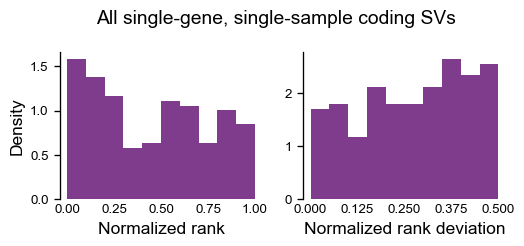

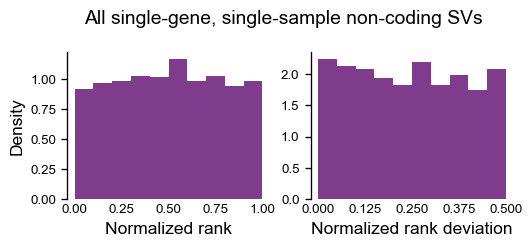

In [8]:
for sv_effect in ['coding', 'non-coding']:
    
    ss_sg_svs = single_gene_sample_svs.query(f'sv_effect == "{sv_effect}"')
    rank_deviation = np.abs(0.5 - ss_sg_svs['mean_greater_0_dosage_rank'])
    
    fig, axes = plt.subplots(1, 2, figsize = (6, 2))
    axes[0].hist(ss_sg_svs['mean_greater_0_dosage_rank'], 
                 bins = np.arange(0, 1.1, 0.1), density = True)
    axes[1].hist(rank_deviation, bins = np.arange(0, 0.55, 0.05),
                 density = True)

    for ax in axes:
        sns.despine(ax = ax, bottom = True)
        ax.tick_params(axis = 'x', length = 0)

    axes[0].set_xlim([-0.04, 1.04])
    axes[1].set_xlim([-0.02, 0.52])
    axes[1].set_xticks([0, 0.125, 0.25, 0.375, 0.5])

    axes[0].set_xlabel('Normalized rank')
    axes[1].set_xlabel('Normalized rank deviation')
    axes[0].set_ylabel('Density')
    
    # calculate a p value
    num_genes = len(ss_sg_svs)
    ref_dist = stats.norm(loc = 0.25, scale = np.sqrt(1/(48 * num_genes)))
    p = 1 - ref_dist.cdf(rank_deviation.mean())
    print(sv_effect, 'p =', p)

    fig.suptitle(f'All single-gene, single-sample {sv_effect} SVs', y = 1.1)

So the coding SVs do have more of an effect than the noncoding SVs.

In [9]:
genic_rel_cols = {'coding': ['PREDICTED_LOF', 'PREDICTED_COPY_GAIN', 'PREDICTED_INTRAGENIC_EXON_DUP', 'PREDICTED_PARTIAL_EXON_DUP'],
                  'non-coding': ['PREDICTED_NEAREST_TSS', 'PREDICTED_INTRONIC', 'PREDICTED_UTR', 'PREDICTED_PROMOTER']}

## Examine impact of coding SVs by sv-type

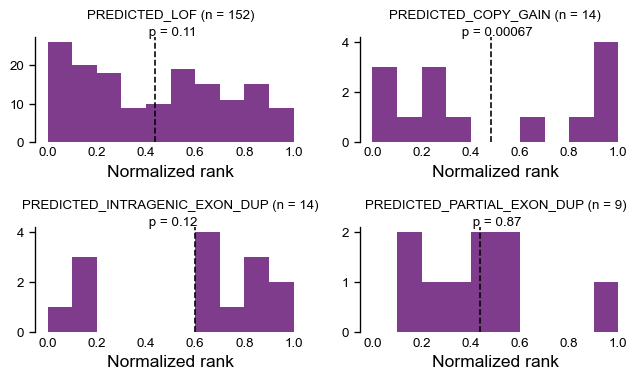

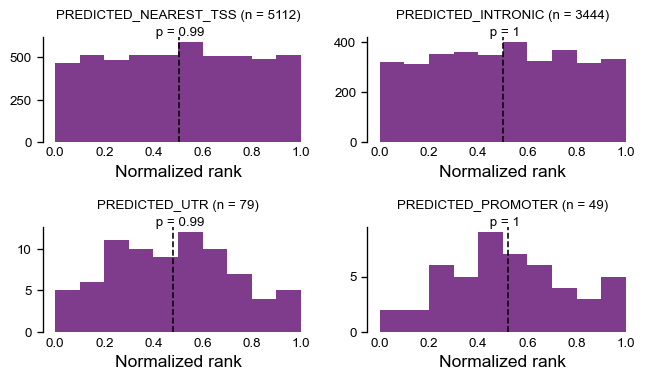

In [10]:
for sv_effect in ['coding', 'non-coding']:
    
    fig, axes = plt.subplots(2, 2, figsize = (8, 4), gridspec_kw = {'hspace': 0.8, 'wspace': 0.2})

    gr_cols = genic_rel_cols[sv_effect]
    ss_sg_svs = single_gene_sample_svs.query(f'sv_effect == "{sv_effect}"')
    
    for i, svtype in enumerate(gr_cols):

        ax = axes.flat[i]
        sv_subset = ss_sg_svs[ss_sg_svs['genic_relationship'] == svtype]
        num_genes = len(sv_subset)

        ax.hist(sv_subset['mean_greater_0_dosage_rank'],
                bins = np.arange(0, 1.1, 0.1), 
                label = svtype)
    
        sns.despine(ax = ax, bottom = True)
        ax.tick_params(axis = 'x', length = 0)
        ax.set_title(svtype + f' (n = {num_genes})', fontsize = 10, y = 1.1)

        num_genes = len(sv_subset)
        rank_deviation = np.abs(0.5 - sv_subset['mean_greater_0_dosage_rank'])
        ref_dist = stats.norm(loc = 0.25, scale = np.sqrt(1/(48 * num_genes)))
        p = 1 - ref_dist.cdf(rank_deviation.mean())
        ax.text(s = " p = {:.2g}".format(p), x = 0.5, y = 1.1, fontsize = 10,
                ha = 'center', va = 'top', transform = ax.transAxes)
        ax.set_xlabel('Normalized rank')

        mean = np.mean(sv_subset['mean_greater_0_dosage_rank'])
        ax.axvline(x = mean, color = 'black', linestyle = 'dashed')

That is super interesting... none of the different categories are significant except for copy gain--but even copy gain has several samples with very low ranks.

# Dig more into these coding effects

So apparently, coding SVs do have detectable effects on expression, and the direction of effect is slanted towards decreasing expression. I'd like to dig into this a little bit more.

In [11]:
coding_ss_sg_svs = single_gene_sample_svs.query('sv_effect == "coding"').copy()

Is there anything else that might explain some results here?

In [12]:
coding_ss_sg_svs['mean_greater_0_dosage_rank'].mean()

0.45051055223149283

Is there some issue with genotyping many of these SVs?

In [13]:
stats.spearmanr(coding_ss_sg_svs['num_samples_genotyped'], coding_ss_sg_svs['mean_greater_0_dosage_rank'])

SpearmanrResult(correlation=-0.011636030263743782, pvalue=0.8737373254833949)

Nope. Is it that highly expressed genes are more likely to have higher ranks?

In [14]:
stats.spearmanr(coding_ss_sg_svs['mean_exp'], coding_ss_sg_svs['mean_greater_0_dosage_rank'])

SpearmanrResult(correlation=-0.0901427593387281, pvalue=0.21737071390423518)

Nope. What about DEL vs. DUP, etc?

In [15]:
coding_ss_sg_svs['svtype'].value_counts()

DEL           138
DUP            44
CPX             3
INV             3
INS:ME:ALU      1
Name: svtype, dtype: int64

In [16]:
for svtype in ['DEL', 'DUP']:
    
    svtype_subset = coding_ss_sg_svs.query(f'svtype == "{svtype}"')
    
    num_genes = len(svtype_subset)
    rank_deviation = np.abs(0.5 - svtype_subset['mean_greater_0_dosage_rank'])
    ref_dist = stats.norm(loc = 0.25, scale = np.sqrt(1/(48 * num_genes)))
    p = 1 - ref_dist.cdf(rank_deviation.mean())
    
    print(svtype, rank_deviation.mean(), p)

DEL 0.2664207133454066 0.09070138468686295
DUP 0.286055254880091 0.04876243027274063


Interesting, so DUPs maybe have a slightly higher effect size?

Nope, that's not it. Is it that these data actually represent a fraction of the total overall samples? Like for some reason, this is just reflecting the influence of some weird samples?

In [17]:
coding_sv_names = coding_ss_sg_svs['name'].tolist()
coding_sv_dosages = analysis_dosages.loc[coding_sv_names]

samples = []
for index, row in coding_sv_dosages.iterrows():
    s = row[row > 0]
    assert len(s) == 1
    
    samples.append(s.index[0])
    
sample_counts = pd.DataFrame(np.unique(samples, return_counts = True), index = ['sample', 'count']).T
sample_counts = sample_counts.sort_values(by = 'count', ascending = False)

In [18]:
sample_counts.head(6)

,sample,count
26,PT_AGYJR7PZ,8
44,PT_JD8FVX6G,6
35,PT_F0QD1YWQ,6
59,PT_RVTVP55V,5
52,PT_P111JVHP,5
24,PT_9X3MV3GW,5


In [19]:
sample_counts.shape

(75, 2)

So 75 out of 89 samples are represented here, which isn't bad. But that doesn't tell us if a subset of samples are actually driving the signal or not. Need to do a bit more work to figure that out.

In [20]:
coding_ss_sg_svs['rank_deviation'] = np.abs(0.5 - coding_ss_sg_svs['mean_greater_0_dosage_rank'])
coding_ss_sg_svs['sample_affected'] = samples

In [21]:
# how many samples have at least one SV in the top or bottom 10% by rank?
coding_ss_sg_svs['extreme_rank'] = coding_ss_sg_svs['rank_deviation'] > 0.40
num_extreme = coding_ss_sg_svs[coding_ss_sg_svs['extreme_rank']]['sample_affected'].value_counts()
print(num_extreme.shape[0], '\n')
print(num_extreme.head(5))

34 

PT_AGYJR7PZ    6
PT_11XN6CG5    2
PT_1RH3DTPB    2
PT_GSWXPFPQ    2
PT_9X3MV3GW    2
Name: sample_affected, dtype: int64


So 34 out of 75 of those samples have expression in an extreme rank, which I think is a good sign. Can we just check that if we subsample to individual samples, we get similar results?

In [22]:
p_vals = []
for i in range(10000):
    temp = coding_ss_sg_svs.sample(frac=1, replace = False)
    temp = temp.drop_duplicates(subset = ['sample_affected'])
    
    ref_dist = stats.norm(loc = 0.25, scale = np.sqrt(1/(48 * len(temp))))
    p = 1 - ref_dist.cdf(temp['rank_deviation'].mean())
    p_vals.append(p)

In [23]:
(np.array(p_vals) < 0.05).mean()

0.3851

Interesting. Only 38% of the time, this subselection process results in a significant result. What if we drop samples that have more than 4 counts?

In [24]:
for cutoff in [4, 3, 2, 1]:
    fewer_than = sample_counts[sample_counts['count'] <= cutoff]['sample'].tolist()
    subset = coding_ss_sg_svs[coding_ss_sg_svs['sample_affected'].isin(fewer_than)]
    
    ref_dist = stats.norm(loc = 0.25, scale = np.sqrt(1/(48 * len(subset))))
    p = 1 - ref_dist.cdf(subset['rank_deviation'].mean())
    
    print(subset['rank_deviation'].mean(), p)

0.27539557175268103 0.015869165114099526
0.26887164308269823 0.07189921987273318
0.2780683941473703 0.06762666005790574
0.28933584462915835 0.1058555172807597


Still significant, and it remains borderline significant even as you drop it more. So I don't think individual samples are influencing things all that much. Interesting!

## Examine other coding contexts

I want to examine other coding contexts:

- Common SVs (those that affect many samples)
- CNVs

In [25]:
coding_results = sv_rna_results.query('sv_effect == "coding"')

Let's examine SVs that have at least 4 samples with the SV. We'll stick with only SVs that affect one gene.

In [26]:
# select SVs with a good mix of samples with the SV and those without
high_af_coding_svs = coding_results[(coding_results['num_samples_nonzero'] >= 4) &
                                    (coding_results['num_samples_genotyped'] - coding_results['num_samples_nonzero'] >= 4)].copy()
high_af_coding_svs.shape

(111, 22)

How many are significant?

In [27]:
# sig_subset = high_af_coding_svs.query('mwu_p < 0.05').copy()
high_af_coding_svs['log2FC'] = np.log2(high_af_coding_svs['mean_greater_0_exp'] / high_af_coding_svs['mean_leq_0_exp'])
high_af_coding_svs['-logp'] = -np.log10(high_af_coding_svs['mwu_p'])

<AxesSubplot:xlabel='log2FC', ylabel='-logp'>

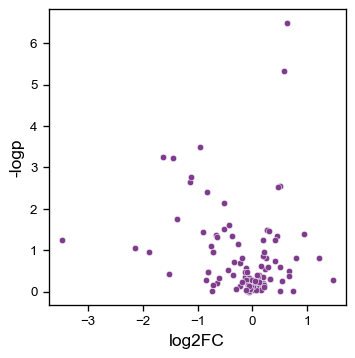

In [28]:
sns.scatterplot(x = 'log2FC', y = '-logp', data = high_af_coding_svs)

# Examine our categories

We start by importing our category data

In [29]:
###########
### SVs ###
###########
nbl_coding_svs = pd.read_csv(
    "data/CWAS data for Jett/List of variants by category for each CWAS analysis/neuroblastoma_all_coding_SVs_in_each_category_list_combined_11_3_23.txt",
    sep="\t",
)

nbl_noncoding_svs = pd.read_csv('data/CWAS data for Jett/List of variants by category for each CWAS analysis/neuroblastoma_all_noncoding_SVs_in_each_category_list_combined_BURDEN_TESTING_with_col_names_11_3_23.txt', sep='\t')
nbl_noncoding_svs = nbl_noncoding_svs.rename(columns = {'emd': 'end'})

# combine the SVs
nbl_coding_svs['sv_category'] = 'coding'
nbl_noncoding_svs['sv_category'] = 'non-coding'

nbl_category_svs = pd.concat([nbl_coding_svs, nbl_noncoding_svs])
nbl_category_svs.head(2)

,SV,chrom,start,end,category,sv_category
0,PedSV.2.5.2_DUP_chr1_794,chr1,19221626,19301822,DUP.RARE.PREDICTED_COPY_GAIN.lof_constrained.e...,coding
1,PedSV.2.5.2_DUP_chr1_1379,chr1,44731601,44792024,DUP.RARE.PREDICTED_COPY_GAIN.lof_constrained.e...,coding


In [30]:
#########################
### FRAMEWORK RESULTS ###
#########################
nbl_singleton_coding_framework_results = pd.read_csv(
    "data/CWAS data for Jett/CWAS sum stats/neuroblastoma_all_coding_cwas_concatenated_glm_results_SINGLETON_11_3_23.txt",
    sep="\t",
)
nbl_singleton_coding_framework_results[['af_category', 'sv_category']] = ['singleton', 'coding']

nbl_rare_coding_framework_results = pd.read_csv(
    "data/CWAS data for Jett/CWAS sum stats/neuroblastoma_all_coding_cwas_concatenated_glm_results_RARE_11_3_23.txt",
    sep="\t",
)
nbl_rare_coding_framework_results[['af_category', 'sv_category']] = ['rare', 'coding']

nbl_singleton_noncoding_framework_results = pd.read_csv(
    "data/CWAS data for Jett/CWAS sum stats/neuroblastoma_all_noncoding_cwas_concatenated_glm_results_SINGLETON_11_3_23.txt",
    sep="\t",
)
nbl_singleton_noncoding_framework_results[['af_category', 'sv_category']] = ['singleton', 'non-coding']

nbl_rare_noncoding_framework_results = pd.read_csv(
    "data/CWAS data for Jett/CWAS sum stats/neuroblastoma_all_noncoding_cwas_concatenated_glm_results_RARE_11_3_23.txt",
    sep="\t",
)
nbl_rare_noncoding_framework_results[['af_category', 'sv_category']] = ['rare', 'non-coding']

nbl_framework_results = pd.concat([nbl_singleton_coding_framework_results, nbl_rare_coding_framework_results, 
                                   nbl_singleton_noncoding_framework_results, nbl_rare_noncoding_framework_results])

In [31]:
nbl_framework_results.head(2)

,point_estimate,std_error,z_score,p_value,SV_counts_cases,SV_counts_cases_max,number_of_cases_with_zero_SVs,total_cases,SV_counts_controls,SV_counts_controls_max,number_of_controls_with_zero_SVs,total_controls,number_of_unique_SVs,category_name,sv_type,frequency,mean_SVs_per_case,mean_SVs_per_control,mean_SVs_total,negative_log10_p_value,af_category,sv_category
0,0.271918,0.051227,5.308100,1.110000e-07,438,5,336,646,2441,4,2848,4700,459,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...,ANY,SINGLETON,0.678019,0.519362,0.538533,6.955563,singleton,coding
1,0.276065,0.054006,5.111756,3.190000e-07,393,5,356,646,2172,4,3012,4700,411,DEL.SINGLETON.ANY.ANY.ANY.protein_coding,DEL,SINGLETON,0.608359,0.462128,0.479798,6.495968,singleton,coding


In [32]:
nbl_coding_framework = pd.read_csv(
    "data/CWAS data for Jett/CWAS frameworks/CWAS_categories_neuroblastoma_coding_8_17_23.txt",
    sep="\t",
)

nbl_noncoding_framework = pd.read_csv(
    "data/CWAS data for Jett/CWAS frameworks/CWAS_rare_categories_neuroblastoma_noncoding_10_2_23.txt",
    sep="\t",
)

## Show an example

We'll replicate an example we've done previously

In [ ]:
significant_categories = nbl_framework_results.query('negative_log10_p_value > 3.5')
coding_categories = significant_categories.query('sv_category == "coding"')

In [70]:
significant_categories.head(2)

,point_estimate,std_error,z_score,p_value,SV_counts_cases,SV_counts_cases_max,number_of_cases_with_zero_SVs,total_cases,SV_counts_controls,SV_counts_controls_max,number_of_controls_with_zero_SVs,total_controls,number_of_unique_SVs,category_name,sv_type,frequency,mean_SVs_per_case,mean_SVs_per_control,mean_SVs_total,negative_log10_p_value,af_category,sv_category
0,0.271918,0.051227,5.308100,1.110000e-07,438,5,336,646,2441,4,2848,4700,459,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...,ANY,SINGLETON,0.678019,0.519362,0.538533,6.955563,singleton,coding
1,0.276065,0.054006,5.111756,3.190000e-07,393,5,356,646,2172,4,3012,4700,411,DEL.SINGLETON.ANY.ANY.ANY.protein_coding,DEL,SINGLETON,0.608359,0.462128,0.479798,6.495968,singleton,coding


In [86]:
p_vals = []
for index, row in significant_categories.iterrows():
    cat = row['category_name']
    sv_effect = row['sv_category']
    
    svs_in_category = nbl_category_svs[nbl_category_svs['category'] == cat]['SV'].tolist()

    category_rna_results = sv_rna_results[sv_rna_results['name'].isin(svs_in_category)]
    
    
    category_rna_results = category_rna_results[(category_rna_results[f'sv_{sv_effect}_counts'] == 1) & 
                                                (category_rna_results['sv_effect'] == sv_effect)]
    
    try:
        rank_deviation = np.mean(np.abs(0.5 - category_rna_results['mean_greater_0_dosage_rank']))
    
        num_genes = len(category_rna_results)
        ref_dist = stats.norm(loc = 0.25, scale = np.sqrt(1/(48 * num_genes)))
        p_mean = 1 - ref_dist.cdf(rank_deviation)
        
    except:
        p_mean = np.nan
        
    p_vals.append([cat, p_mean])
    
p_vals = pd.DataFrame(p_vals, columns = ['category_name', 'p_mean'])

In [94]:
test = significant_categories.merge(p_vals, on = 'category_name')
test['-log10(cat_p)'] = -np.log10(test['p_value'])
test['-log10(p_mean)'] = -np.log10(test['p_mean'])

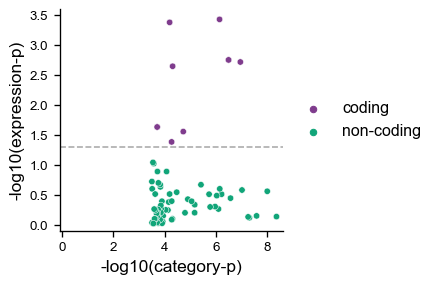

In [96]:
fig, ax = plt.subplots(1, figsize = (3, 3))
sns.scatterplot(x = '-log10(cat_p)', y = '-log10(p_mean)', data = test, hue = 'sv_category')
ax.set_xlabel('-log10(category-p)')
ax.set_ylabel('-log10(expression-p)')
sns.despine(ax = ax)
ax.set_xlim([-0.1, None])
ax.set_ylim([-0.1, None])
ax.axhline(y = -np.log10(0.05), linestyle = 'dashed', color = 'darkgrey')
ax.legend(bbox_to_anchor = (1, 0.5))
# fig.savefig('data/cwas-results/expression-significance.png', bbox_inches = 'tight')

In [84]:
sv_rna_results[sv_rna_results['name'].isin(svs_in_category)]

,name,#chrom,start,end,svtype,sv_coding_counts,sv_non-coding_counts,num_samples_nonzero,num_samples_genotyped,af,average_cn,sv_effect,genic_relationship,gene,mean_exp,num_greater_0_dosage,mean_greater_0_dosage_rank,mean_greater_0_exp,mean_leq_0_exp,mwu_p,ordinal_p,ordinal_coef


In [85]:
svs_in_category

['PedSV.2.5.2_DEL_chr1_6001',
 'PedSV.2.5.2_DEL_chr3_2683',
 'PedSV.2.5.2_DEL_chr3_11124',
 'PedSV.2.5.2_DEL_chr4_4249',
 'PedSV.2.5.2_DEL_chr5_11513',
 'PedSV.2.5.2_DEL_chr8_3499',
 'PedSV.2.5.2_DEL_chr8_8021',
 'PedSV.2.5.2_DEL_chr8_8634',
 'PedSV.2.5.2_DEL_chr9_1335',
 'PedSV.2.5.2_DEL_chr9_1336',
 'PedSV.2.5.2_DEL_chr12_4257',
 'PedSV.2.5.2_DEL_chr13_2013',
 'PedSV.2.5.2_DEL_chr17_3617',
 'PedSV.2.5.2_DEL_chr18_1598',
 'PedSV.2.5.2_DEL_chr18_3905',
 'PedSV.2.5.2_DEL_chr19_3555',
 'PedSV.2.5.2_DEL_chr20_4402']

In [72]:
category_rna_results

,name,#chrom,start,end,svtype,sv_coding_counts,sv_non-coding_counts,num_samples_nonzero,num_samples_genotyped,af,average_cn,sv_effect,genic_relationship,gene,mean_exp,num_greater_0_dosage,mean_greater_0_dosage_rank,mean_greater_0_exp,mean_leq_0_exp,mwu_p,ordinal_p,ordinal_coef
103,PedSV.2.5.2_DEL_chr1_833,chr1,3624391,3626648,DEL,1.0,0.0,1,89,0.005618,NaN,coding,PREDICTED_LOF,TPRG1L,7.245281,1,0.102273,2.55,7.298636,0.179293,0.127798,-2.221534
744,PedSV.2.5.2_DEL_chr1_6558,chr1,75756380,75781746,DEL,1.0,0.0,1,89,0.005618,NaN,coding,PREDICTED_LOF,ACADM,24.638539,1,0.045455,10.89,24.794773,0.124161,0.036362,-3.163294
1220,PedSV.2.5.2_DEL_chr1_11111,chr1,168185598,168209102,DEL,1.0,0.0,1,89,0.005618,NaN,coding,PREDICTED_LOF,TIPRL,9.978652,1,0.136364,5.86,10.025455,0.220142,0.194192,-1.880881
2231,PedSV.2.5.2_DEL_chr2_2398,chr2,26439986,26444381,DEL,1.0,0.0,1,89,0.005618,NaN,coding,PREDICTED_LOF,DRC1,0.279438,1,0.539773,0.23,0.280000,0.906900,0.910266,0.161207
2439,PedSV.2.5.2_DEL_chr2_4206,chr2,51008702,51080243,DEL,1.0,0.0,1,89,0.005618,NaN,coding,PREDICTED_LOF,NRXN1,74.604719,1,0.227273,39.42,75.004545,0.471910,0.387700,-1.241447
3080,PedSV.2.5.2_DEL_chr2_9420,chr2,133514618,133549619,DEL,1.0,0.0,1,81,0.006173,NaN,coding,PREDICTED_LOF,NCKAP5,5.653704,1,0.887500,10.83,5.589000,0.192066,0.147440,2.113965
3617,PedSV.2.5.2_DEL_chr2_12852,chr2,196784047,196785865,DEL,1.0,0.0,1,89,0.005618,NaN,coding,PREDICTED_LOF,GTF3C3,16.785618,1,0.000000,4.39,16.926477,0.090409,NaN,-44.217720
3663,PedSV.2.5.2_DEL_chr2_13235,chr2,203454092,203456977,DEL,1.0,0.0,1,89,0.005618,NaN,coding,PREDICTED_LOF,RAPH1,19.394270,1,0.693182,21.60,19.369205,0.520700,0.564695,0.825319
3753,PedSV.2.5.2_DEL_chr2_13835,chr2,213345618,213355619,DEL,1.0,0.0,1,81,0.006173,NaN,coding,PREDICTED_LOF,SPAG16,10.035802,1,0.712500,12.72,10.002250,0.480367,0.521439,0.920562
4024,PedSV.2.5.2_DEL_chr2_15718,chr2,238102594,238104958,DEL,1.0,0.0,1,89,0.005618,NaN,coding,PREDICTED_LOF,ESPNL,0.399663,1,0.977273,2.10,0.380341,0.106089,0.013074,4.003032


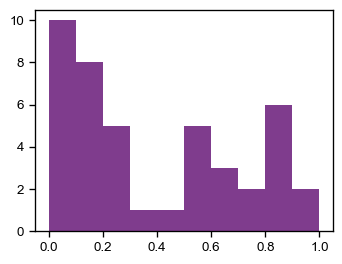

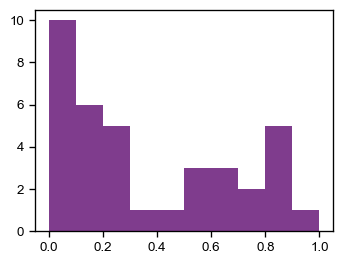

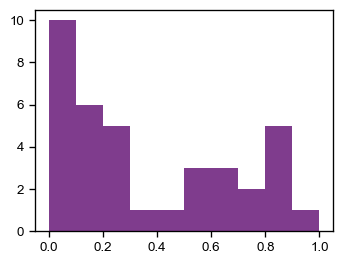

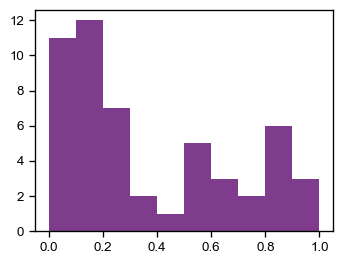

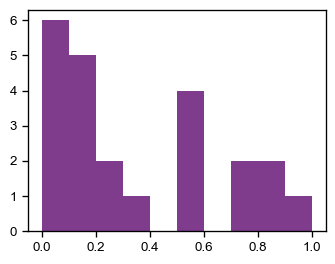

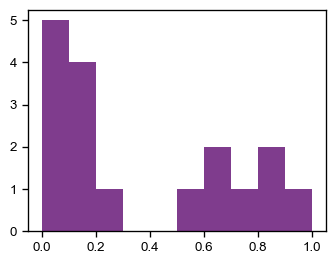

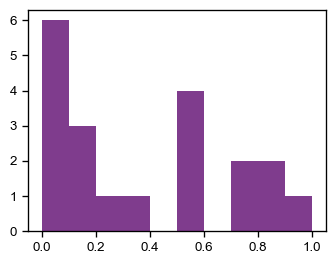

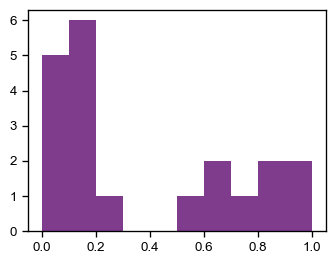

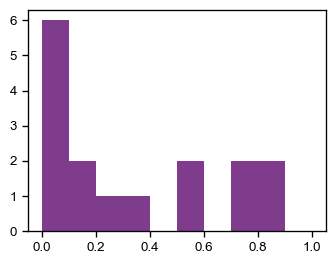

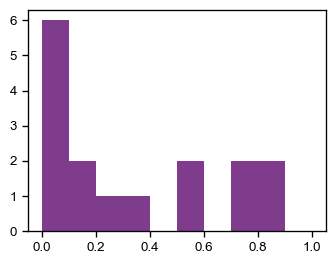

In [68]:
for cat in coding_categories['category_name'].tolist():
    svs_in_category = nbl_category_svs[nbl_category_svs['category'] == cat]['SV'].tolist()

    category_rna_results = sv_rna_results[sv_rna_results['name'].isin(svs_in_category)]
    category_rna_results = category_rna_results.query('sv_coding_counts == 1 & sv_effect == "coding"')
    
    fig, ax = plt.subplots(1, figsize = (4, 3))
    ax.hist(category_rna_results['mean_greater_0_dosage_rank'], bins = np.arange(0, 1.1, 0.1));

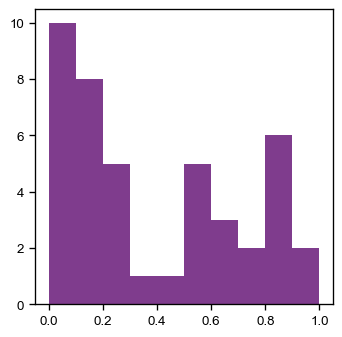

In [58]:
plt.hist(category_rna_results['mean_greater_0_dosage_rank'], bins = np.arange(0, 1.1, 0.1));

In [56]:
category_rna_results['mean_greater_0_dosage_rank'].mean()

0.3917796432568166

In [48]:
category_rna_results

,name,#chrom,start,end,svtype,sv_coding_counts,sv_non-coding_counts,num_samples_nonzero,num_samples_genotyped,af,average_cn,sv_effect,genic_relationship,gene,mean_exp,num_greater_0_dosage,mean_greater_0_dosage_rank,mean_greater_0_exp,mean_leq_0_exp,mwu_p,ordinal_p,ordinal_coef
103,PedSV.2.5.2_DEL_chr1_833,chr1,3624391,3626648,DEL,1.0,0.0,1,89,0.005618,NaN,coding,PREDICTED_LOF,TPRG1L,7.245281,1,0.102273,2.55,7.298636,0.179293,0.127798,-2.221534
744,PedSV.2.5.2_DEL_chr1_6558,chr1,75756380,75781746,DEL,1.0,0.0,1,89,0.005618,NaN,coding,PREDICTED_LOF,ACADM,24.638539,1,0.045455,10.89,24.794773,0.124161,0.036362,-3.163294
1220,PedSV.2.5.2_DEL_chr1_11111,chr1,168185598,168209102,DEL,1.0,0.0,1,89,0.005618,NaN,coding,PREDICTED_LOF,TIPRL,9.978652,1,0.136364,5.86,10.025455,0.220142,0.194192,-1.880881
2231,PedSV.2.5.2_DEL_chr2_2398,chr2,26439986,26444381,DEL,1.0,0.0,1,89,0.005618,NaN,coding,PREDICTED_LOF,DRC1,0.279438,1,0.539773,0.23,0.280000,0.906900,0.910266,0.161207
2439,PedSV.2.5.2_DEL_chr2_4206,chr2,51008702,51080243,DEL,1.0,0.0,1,89,0.005618,NaN,coding,PREDICTED_LOF,NRXN1,74.604719,1,0.227273,39.42,75.004545,0.471910,0.387700,-1.241447
3080,PedSV.2.5.2_DEL_chr2_9420,chr2,133514618,133549619,DEL,1.0,0.0,1,81,0.006173,NaN,coding,PREDICTED_LOF,NCKAP5,5.653704,1,0.887500,10.83,5.589000,0.192066,0.147440,2.113965
3446,PedSV.2.5.2_DEL_chr2_11771,chr2,177741637,178179297,DEL,2.0,0.0,1,89,0.005618,NaN,coding,PREDICTED_LOF,RBM45,6.366742,1,0.306818,4.71,6.385568,0.520696,0.564683,-0.825347
3617,PedSV.2.5.2_DEL_chr2_12852,chr2,196784047,196785865,DEL,1.0,0.0,1,89,0.005618,NaN,coding,PREDICTED_LOF,GTF3C3,16.785618,1,0.000000,4.39,16.926477,0.090409,NaN,-44.217720
3663,PedSV.2.5.2_DEL_chr2_13235,chr2,203454092,203456977,DEL,1.0,0.0,1,89,0.005618,NaN,coding,PREDICTED_LOF,RAPH1,19.394270,1,0.693182,21.60,19.369205,0.520700,0.564695,0.825319
3753,PedSV.2.5.2_DEL_chr2_13835,chr2,213345618,213355619,DEL,1.0,0.0,1,81,0.006173,NaN,coding,PREDICTED_LOF,SPAG16,10.035802,1,0.712500,12.72,10.002250,0.480367,0.521439,0.920562


In [36]:
sv_rna_results

,name,#chrom,start,end,svtype,sv_coding_counts,sv_non-coding_counts,num_samples_nonzero,num_samples_genotyped,af,average_cn,sv_effect,genic_relationship,gene,mean_exp,num_greater_0_dosage,mean_greater_0_dosage_rank,mean_greater_0_exp,mean_leq_0_exp,mwu_p,ordinal_p,ordinal_coef
0,PedSV.2.5.2_CNV_chr1_6,chr1,257666,262901,CNV,0.0,1.0,17,89,NaN,0.179775,non-coding,PREDICTED_NEAREST_TSS,OR4F29,0.266629,15,0.492045,0.247333,0.270541,0.912668,0.582179,-0.188116
1,PedSV.2.5.2_CNV_chr1_7,chr1,262333,288667,CNV,0.0,1.0,62,89,NaN,0.932584,non-coding,PREDICTED_NEAREST_TSS,OR4F29,0.266629,62,0.489736,0.255484,0.292222,0.620135,0.461080,-0.181469
2,PedSV.2.5.2_CNV_chr1_8,chr1,431000,436001,CNV,0.0,1.0,8,89,NaN,0.089888,non-coding,PREDICTED_NEAREST_TSS,OR4F29,0.266629,7,0.330357,0.128571,0.278415,0.112705,0.285824,-0.469457
3,PedSV.2.5.2_CNV_chr1_9,chr1,585988,596501,CNV,0.0,1.0,23,89,NaN,-0.134831,non-coding,PREDICTED_NEAREST_TSS,OR4F16,0.266629,6,0.532197,0.275000,0.266024,0.787030,0.059611,0.692249
4,PedSV.2.5.2_DEL_chr1_14,chr1,600354,600737,DEL,0.0,1.0,1,89,0.005618,NaN,non-coding,PREDICTED_NEAREST_TSS,OR4F16,0.266629,1,0.818182,0.410000,0.265000,0.284093,0.289008,1.528343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25178,PedSV.2.5.2_DEL_chrX_9199,chrX,155551128,155556252,DEL,0.0,1.0,1,85,0.005882,NaN,non-coding,PREDICTED_INTRONIC,TMLHE,6.893294,1,0.333333,4.960000,6.916310,0.582156,0.624238,-0.702048
25179,PedSV.2.5.2_DEL_chrX_9201,chrX,155552029,155557969,DEL,0.0,1.0,1,85,0.005882,NaN,non-coding,PREDICTED_INTRONIC,TMLHE,6.893294,1,0.333333,4.960000,6.916310,0.582156,0.624238,-0.702048
25180,PedSV.2.5.2_DEL_chrX_9209,chrX,155560501,155560768,DEL,0.0,1.0,4,89,0.022472,NaN,non-coding,PREDICTED_INTRONIC,TMLHE,6.818427,4,0.392045,5.382500,6.886000,0.457704,0.516950,-0.485093
25181,PedSV.2.5.2_INS_chrX_2887,chrX,155560527,155560528,INS,0.0,1.0,68,89,0.398876,NaN,non-coding,PREDICTED_INTRONIC,TMLHE,6.818427,68,0.471758,6.523971,7.771905,0.103474,0.245370,-0.439022
